In [3]:
# importing libaries
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import math as math

In [4]:
#read data 
data = pd.read_csv('Almeria_Airp_-hour.dat',delimiter='\t')
data = data[1:].astype(float)
data.Ta +=273.15 #convert to Kelvin
data['date_time'] = pd.to_datetime({'year':2022,'month':data.m,'day':data.dofm,'hour':data.hi})

In [5]:
'''dofm: day of month
    dofy: day of the year
    hi: hour of the day
    Ta: temperature of air
    G_Gh: 
    Td: dew point temperature
    RH: relative himidity (%)
    G_DH: 
    FF: wind speed (m/s)
    DD: wind direction
    Lin: longwave radiation from the atmosphere
    RR: preciptation
    Sd: effective sunshine duration
    N: cloud cover
    hs: solar altitude
    TL: 
    G_Bn: 
    G_Gc: 
    GEX: Extraterrestrial radiation
    G_Ghmod: 
    PAR: Photosynthetically active radiation
    Snd: 
    Lup: Longwave (thermal, infrared) radiation on horizontal surface emitted from the earth's surface (longwave 
        outgoing) wavelength > 3 µm
'''
data.N.describe()


count    8760.000000
mean        2.101142
std         2.625161
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max         8.000000
Name: N, dtype: float64

In [6]:
sigma = 5.670374419*10**-8          # boltzman constant 
tau_reactor = 0.92                  # transmittance according to manufacturer taken when not filled with water
epsilon_reactor = 0.97              # emsivity of water
R_reactor = (65-2.2)/2*10**-3           # according to manufacurer
L = 1                               # an arbitraty length of a meter of reactor is used
rho_reactor = 997                            # desity of water
cp_reactor = 4186                          # soortelijke warmte water volgens wikipedia J/(Kg*K)
V_reactor = L*math.pi*R_reactor**2      # reactor volume in m^3 
epsilon_air = 1                     # value used in paper mechanistic modeling 
dilution_rate = 0.05/3600                 # random suggestion
T_in = 273.15+13
aeration_rate = 1*V_reactor/3600       #arbitrary aeration rate in volume/time unit  
R = 8.314                                        # ideal gas constant
A = 8.07131                                      # constant for antoines law found on the wikipedia page 
B = 1730.63                                      # constant for antoines law found on the wikipedia page 
C  = 233.426 - 273.15                            # constant for antoines law found on the wikipedia page                       
heat_vap = 40.66*1000                                # heat of vaporization according to table on wikipedia (J/mol)
albedo = 0.3                            # according to wikipedia for grassland
A_cross = 2*R_reactor*L                 # Area cross section

V_reactor


0.003097484692733392

In [7]:
time_int = 3600
t_span = np.array((data.dofy*24+data.hi-24)*time_int)
t_start = 2400+40*24
t_span = t_span[t_start:t_start+240]
t0 = [0]
y0 = [273.15+13]
p = [1, 1]
t_span

array([12099600., 12103200., 12106800., 12110400., 12114000., 12117600.,
       12121200., 12124800., 12128400., 12132000., 12135600., 12139200.,
       12142800., 12146400., 12150000., 12153600., 12157200., 12160800.,
       12164400., 12168000., 12171600., 12175200., 12178800., 12182400.,
       12186000., 12189600., 12193200., 12196800., 12200400., 12204000.,
       12207600., 12211200., 12214800., 12218400., 12222000., 12225600.,
       12229200., 12232800., 12236400., 12240000., 12243600., 12247200.,
       12250800., 12254400., 12258000., 12261600., 12265200., 12268800.,
       12272400., 12276000., 12279600., 12283200., 12286800., 12290400.,
       12294000., 12297600., 12301200., 12304800., 12308400., 12312000.,
       12315600., 12319200., 12322800., 12326400., 12330000., 12333600.,
       12337200., 12340800., 12344400., 12348000., 12351600., 12355200.,
       12358800., 12362400., 12366000., 12369600., 12373200., 12376800.,
       12380400., 12384000., 12387600., 12391200., 

In [8]:
def ground_reflected_rad(t,y,time_index):
    Q = albedo*(data.G_Dh[time_index]+data.Lin[time_index]+data.G_Gh[time_index])*2*R_reactor*L*tau_reactor*epsilon_reactor
    return Q
ground_reflected_rad(1,300,15)

np.float64(14.20682952)

In [9]:
def Q_evap(t,y,time_index):             #perfect equilibrium of water and air is reached at the outlet
    vap_pres_in = 10**(A-(B/(C+data.Ta[time_index])))       #antoines law
    moles_in = vap_pres_in*aeration_rate*(data.RH[time_index]/100)/(R*data.Ta[time_index])
    vap_pres_out = 10**(A-(B/(C+y)))
    moles_out = vap_pres_out*aeration_rate/(R*y) 
    Q = (moles_out-moles_in)* heat_vap
    return -Q
Q_evap(1,300,15)

np.float64(-0.0002645510546506411)

In [10]:
def flow_medium_in(t,y,time_index):
    if data.G_Gh[time_index]>0:         #only harvest when it there is light, since it is only growing in that case
        Q = dilution_rate*T_in*rho_reactor*cp_reactor*V_reactor     # dubblecheck if we are now not replacing the volume every second 
    else:
        Q = 0
    return Q
flow_medium_in(1,273,15)
    

51.376534322995724

In [11]:
def flow_harvest_out(t,y,time_index):
    if data.G_Gh[time_index]>0:         #only harvest when it there is light, since it is only growing in that case
        Q = dilution_rate*y*rho_reactor*cp_reactor*V_reactor     # dubblecheck if we are now not replacing the volume every second 
    else:
        Q = 0
    return -Q
flow_harvest_out(1,300,15)

-53.863219629210974

In [12]:
def ground_infrared_radiation(t,y,time_index):      #assume the Lup value is indeed the emmited ground radiation
    Q = tau_reactor*epsilon_reactor*data.Lup[time_index]*2*R_reactor*L
    return Q
ground_infrared_radiation(1,273,1)

np.float64(21.40831904)

In [13]:
def reactor_infrared_radiation(t,y,time_index):
    Q = L*sigma*tau_reactor*epsilon_reactor*2*math.pi*R_reactor*y**4 
    return -Q
reactor_infrared_radiation(1,273,1)
    

-55.45381162898962

In [14]:
def diffuse_solar_rad(t,y,time_index):
    Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Dh[time_index]
    return Q
diffuse_solar_rad(1,300,15)

np.float64(9.247048799999998)

In [15]:
def direct_solar_rad(t,y,time_index): #in the paper they do something with a formfactor here, check later why
    #Q = tau_reactor*epsilon_reactor*epsilon_air*sigma*R_reactor*2*L*data.G_Gh[time_index] #the amount of sunlight available * intersection area* amount of light not refrlected * light taken up
    Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Gh[time_index]
    return Q
direct_solar_rad(1,273,15)

np.float64(20.455592799999998)

In [16]:
def infrared_rad_air(t,y,time_index):
        #Q = tau_reactor*epsilon_reactor*epsilon_air*2*math.pi*R_reactor*L*sigma*(data.Ta[time_index])**4 
        Q = data.Lin[time_index]*R_reactor*2*L*tau_reactor*epsilon_reactor
        return Q
def infrared_rad_air2(t,y,time_index):
        Q = tau_reactor*epsilon_reactor*epsilon_air*math.pi*R_reactor*L*sigma*(data.Ta[time_index])**4 
        return Q
def infrared_rad_air_rocca(t,y,time_index):
        Cc = data.N[time_index] #cloud coverage 
        Em = 0.937*(10**-5)* (data.Ta[time_index]**2)*(1+0.17*(Cc/8)**2)                # cloud cover divided by 8 because of the scale (octa) used 
        lambda_heat = 0.7
        Q = sigma*(data.Ta[time_index]**4)*math.sqrt(lambda_heat*Em)*epsilon_air*tau_reactor*R_reactor*2*L
        return Q

infrared_rad_air(1,27,1)

np.float64(17.933670399999997)

In [17]:
def convection(t,y,time_index):
    #natural convection:
    g = 9.81                    # gravity constant 
    a_a = 23.07*10**-6                      # air diffusifiy
    v_a =  1.48*10**-5                     #air kinematic viscosity 
    Ra = (g*abs(y-data.Ta[time_index])*L**3)/(a_a*v_a*data.Ta[time_index])
    lambda_a = 0.0260                     # air thermal conductivity accordig to wikipedia
    Pr = 0.7                        #given in paper for a value at 25 C
    # forced convection
    rho_a = 1.293
    mu_a = v_a 
    Re = rho_a*2*R_reactor*data.FF[time_index]/mu_a
    h_forced = lambda_a/(2*R_reactor)*(0.3+0.62*(Re**0.5)*(Pr**(1/3))/(1+(0.4/Pr)**2/3)**0.25)*(1+(Re/282000)**(5/8))**0.8
    h_co = lambda_a/L*(0.825+(0.387*Ra**(1/6))/((1+(0.492/Pr)**(9/16))**8/27))**2
    Q = h_forced*(data.Ta[time_index]-y)*math.pi*R_reactor*L
    return Q
convection(1,300,15)    

np.float64(-34.252269424514594)

In [18]:
#functions
def heat_bal(t,y,p):

    '''creating the measured values at time t as input'''
    time_index = (t//3600)                    # the algorithm loop over this heat balance more often than just for every step, therefore the // to indix to the right values
    u = data.Ta[time_index]
    Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
    Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
    Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
    Q_air_infrared = infrared_rad_air(t,y,time_index)
    Q_medium_added  = flow_medium_in(t,y,time_index)
    Q_broth_out = flow_harvest_out(t,y,time_index)
    Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
    Q_evaporation = Q_evap(t,y,time_index)
    Q_ground_reflected = ground_reflected_rad(t,y,time_index)
    Q_convection =  convection(t,y,time_index)
    '''To be implemented: pump, airation, convection   '''
    dxdt = (Q_direct_solar_rad+Q_diffuse_solar_rad+Q_ground_radiation+Q_medium_added+Q_air_infrared+Q_ground_reflected+Q_react_infrared+Q_broth_out+Q_evaporation+Q_convection)/(rho_reactor*cp_reactor*V_reactor)
    return dxdt
heat_bal(3600,10,1)

np.float64(-6.414926621333524e+58)

C:\Users\matth\AppData\Local\Temp\ipykernel_7172\991693971.py:2: RuntimeWarning: overflow encountered in power
  Q = L*sigma*tau_reactor*epsilon_reactor*2*math.pi*R_reactor*y**4


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.210e+07  1.210e+07 ...  1.296e+07  1.296e+07]
        y: [[ 2.861e+02  2.870e+02 ...  2.861e+02  2.853e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1700
     njev: 0
      nlu: 0


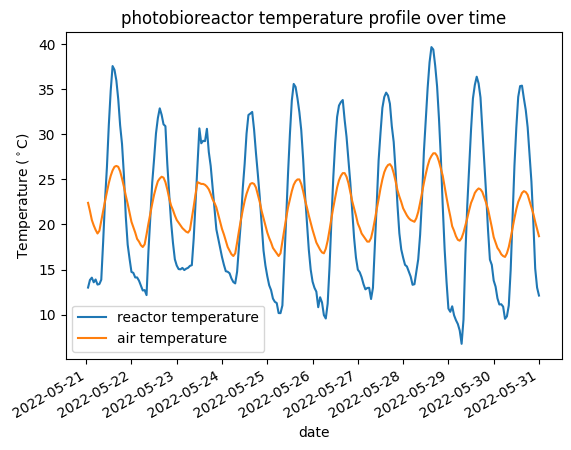

In [19]:
#solver 

solver = integrate.solve_ivp (heat_bal,(t_span[0],t_span[-1]) ,y0, args = [0.01],t_eval=t_span, method='RK45')
#solver = integrate.solve_ivp (heat_bal,[0, t_span[-1]], y0, t_eval=t_span, args = [0.0000001])
print(solver)
t_vals = solver.t
y_vals = solver.y
y_vals = y_vals[0]
hours = t_span/(time_int*24)
air_temp = data.Ta[hours*24]
t_vals_days = 24/hours
time_values = data.date_time[t_span/time_int]
#Q_data = pd.DataFrame(Q_vals,time_values[1:])

##          plot results
plt.xlabel('date')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('photobioreactor temperature profile over time')
plt.plot(time_values, y_vals-273.15,time_values,air_temp-273.15)
plt.gcf().autofmt_xdate()
plt.legend(['reactor temperature','air temperature'])

Text(0, 0.5, 'heat flux (W)')

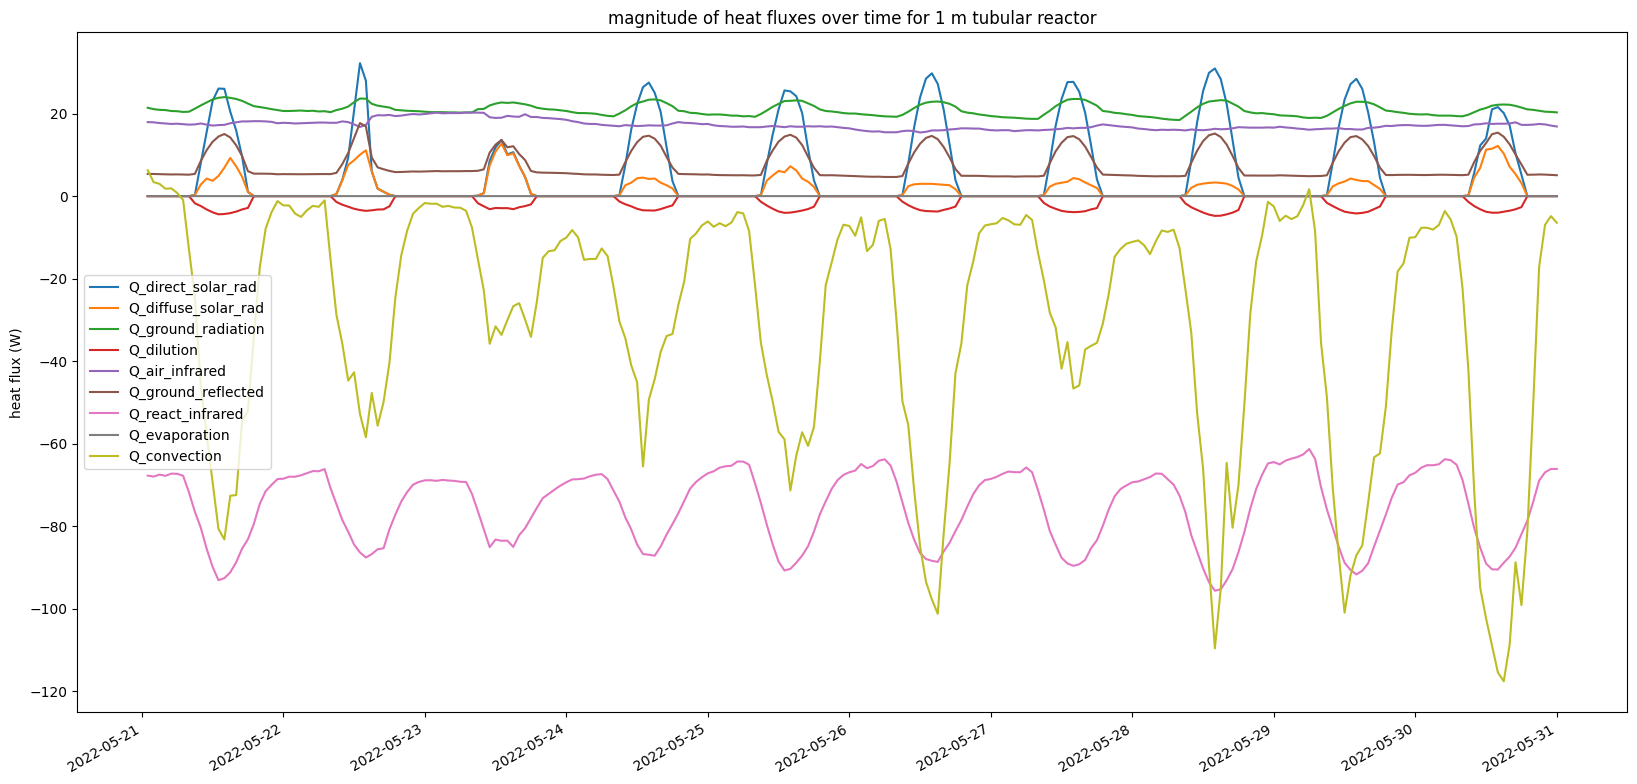

In [23]:
#reverse engineer the heat fluxes, can not extract them directly out of the heat balance function because the integration method
# integration method loops over heat balance multiple times per time step.
Q_data = np.zeros((len(t_vals)+1,9))
time_index = 0
for t in t_vals:
    time_index+=1
    try: 
        y = y_vals[time_index]
    except:
        pass
    
    Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
    Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
    Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
    Q_air_infrared = infrared_rad_air(t,y,time_index)
    Q_dilution  = flow_medium_in(t,y,time_index)+flow_harvest_out(t,y,time_index)
    Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
    Q_evaporation = Q_evap(t,y,time_index)
    Q_ground_reflected = ground_reflected_rad(t,y,time_index)
    Q_convection =  convection(t,y,time_index)
    Q_data[time_index] = [Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_dilution,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_evaporation,Q_convection]
#Q_vals.append([Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_medium_added,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_broth_out,Q_evaporation])
Q_data = Q_data[1:]
columnheader = ['Q_direct_solar_rad','Q_diffuse_solar_rad','Q_ground_radiation','Q_dilution','Q_air_infrared','Q_ground_reflected','Q_react_infrared','Q_evaporation','Q_convection']
Fluxes = pd.DataFrame(Q_data, index= time_values,columns=columnheader)
Fluxes.describe()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(time_values,Fluxes)
plt.legend(columnheader)
plt.gcf().autofmt_xdate()
plt.title('magnitude of heat fluxes over time for 1 m tubular reactor')
plt.ylabel('heat flux (W)')

Text(0, 0.5, 'Heatflux (W)')

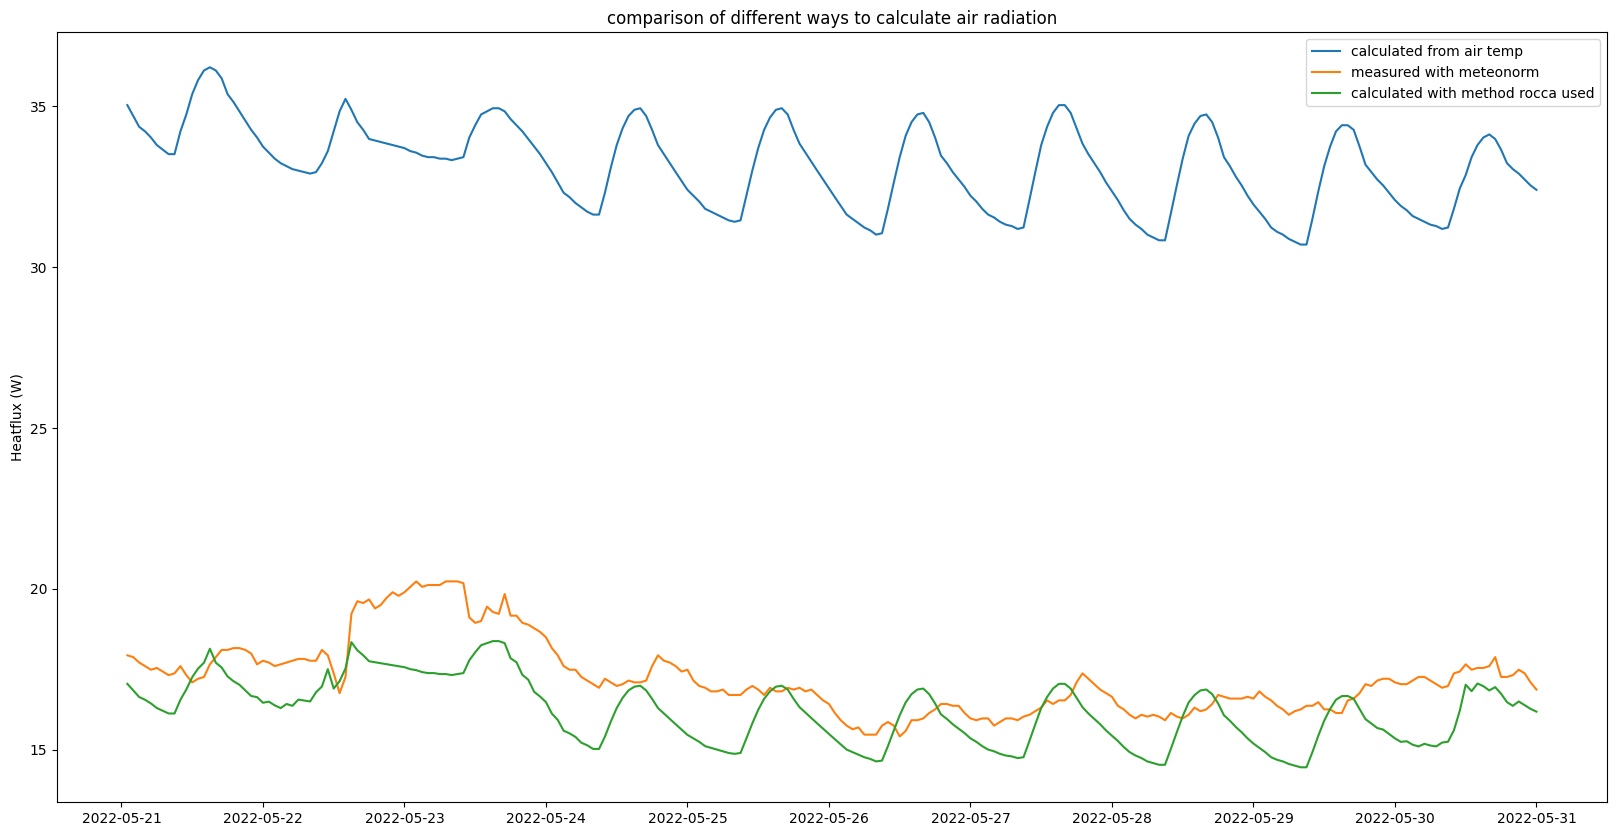

In [25]:
Q_air_calc = []
Q_air_meas = []
Q_air_rocca = []
clouds = []
time_index = 0
for t in t_vals:
    time_index+=1
    try: 
        y = y_vals[time_index]
    except:
        pass
    Q_air_calc.append(infrared_rad_air2(t,y,time_index))
    Q_air_meas.append(infrared_rad_air(t,y,time_index))
    Q_air_rocca.append(infrared_rad_air_rocca(t,y,time_index))
    clouds.append(data.N[time_index])
plt.plot(time_values,Q_air_calc,time_values,Q_air_meas,time_values,Q_air_rocca)
plt.legend(['calculated from air temp','measured with meteonorm','calculated with method rocca used'])
plt.title('comparison of different ways to calculate air radiation' )
plt.axis.titlesize=100
plt.ylabel('Heatflux (W)')


In [68]:
trial = 6//2
trial

3